<a href="https://colab.research.google.com/github/aryan-at-ul/group_project_waves_predictions/blob/main/station_wise_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import sys
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,date,time

In [67]:
path = "/content/drive/MyDrive/imputed_data/M4.csv"
path = "/content/M4.csv"
for_col = "waveheight"
flnn = "M4_waveheight"
date_col = "date"
HORIZON = 1
WINDOW_SIZE = 90
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m")
#.dt.strftime('%m/%d/%Y')
# df = pd.read_csv(path)
# df['date'] = pd.to_datetime(df.date)
# df['date'] = df['date'].dt.strftime('%Y-%m')
# df = df.set_index('date')
df = pd.read_csv(path,parse_dates=[date_col],index_col=[date_col])#,date_parser=custom_date_parser)
df = df.round(3)
df.head()
# offset = 680



,atmosphericpressure,winddirection,windspeed,gust,waveheight,waveperiod,meanwavedirection,hmax,airtemperature,dewpoint,seatemperature,salinity,relativehumidity
date,,,,,,,,,,,,,
2007-05-03,1021.240,42.000,11.267,16.333,0.943,4.933,256.0,4.828,11.207,9.657,12.447,35.1,90.643
2007-05-04,1019.558,58.333,12.125,16.292,1.025,4.333,256.0,4.828,10.729,8.696,12.288,35.1,87.375
2007-05-05,1012.842,210.000,18.417,24.542,1.508,4.667,256.0,4.828,11.829,9.900,12.104,35.1,88.125
2007-05-06,1007.975,243.750,23.958,33.167,4.283,7.542,256.0,4.828,11.254,7.491,11.629,35.1,77.783
2007-05-07,1003.708,245.417,23.667,32.208,3.875,7.208,256.0,4.828,11.046,7.838,11.583,35.1,80.792


In [68]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # implement for season if one knows the season
  return mae / mae_naive_no_season

In [69]:
def evaluate_preds(y_true, y_pred):
    #all values should be as small as possible
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [70]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None,figname = None):

    # Plot the series do not pass df 
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("time")
    plt.ylabel(for_col)
    if label:
        plt.legend(fontsize=14) # make label bigger
    if figname:
        plt.savefig(f'{figname}.png')
    plt.grid(True)

In [71]:
timesteps = df.index.to_numpy()
waveperiod = df[for_col].to_numpy()
timesteps[:10], waveperiod[:10]

(array(['2007-05-03T00:00:00.000000000', '2007-05-04T00:00:00.000000000',
        '2007-05-05T00:00:00.000000000', '2007-05-06T00:00:00.000000000',
        '2007-05-07T00:00:00.000000000', '2007-05-08T00:00:00.000000000',
        '2007-05-09T00:00:00.000000000', '2007-05-10T00:00:00.000000000',
        '2007-05-11T00:00:00.000000000', '2007-05-12T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([0.943, 1.025, 1.508, 4.283, 3.875, 3.354, 2.462, 3.262, 2.321,
        2.408]))

In [72]:
split_size = int(0.8 * len(waveperiod))

In [73]:
X_train, y_train = timesteps[:split_size], waveperiod[:split_size]
X_test, y_test = timesteps[split_size:], waveperiod[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(4196, 1049, 4196, 1049)

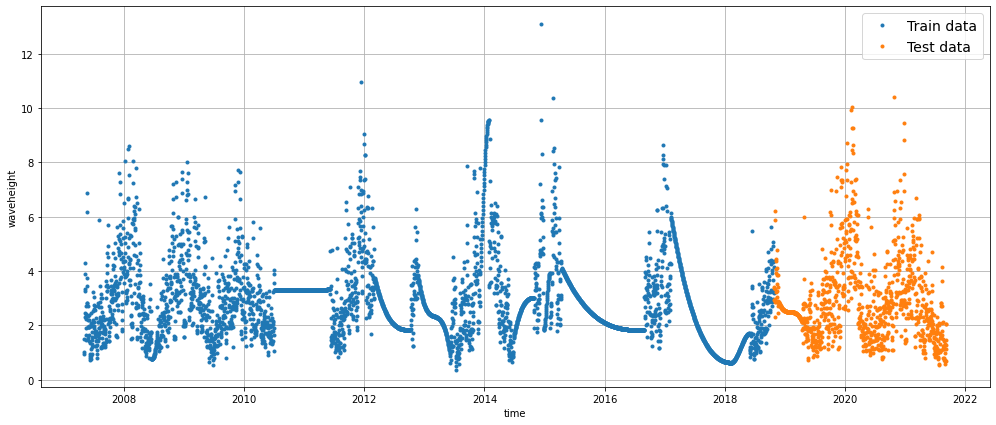

In [74]:
plt.figure(figsize=(17, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data",figname = 'train_and_test_split')

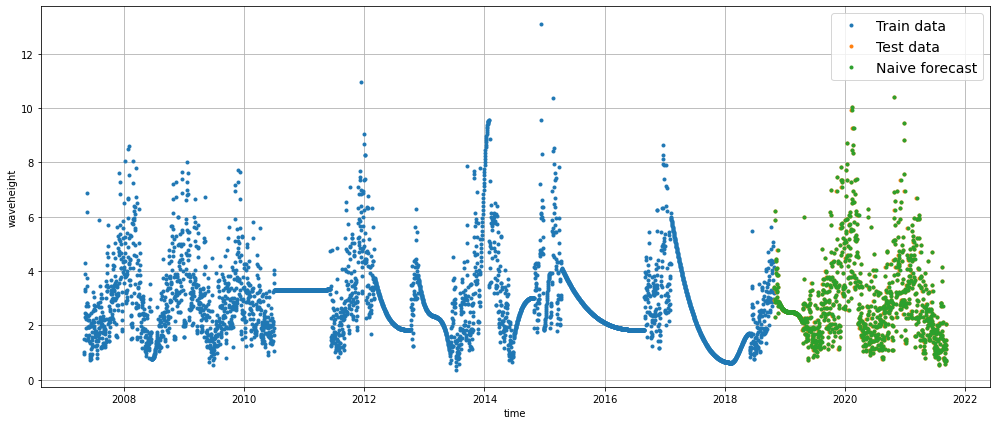

In [75]:
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:]

plt.figure(figsize=(17, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast,label="Naive forecast",figname="prediction_naive");

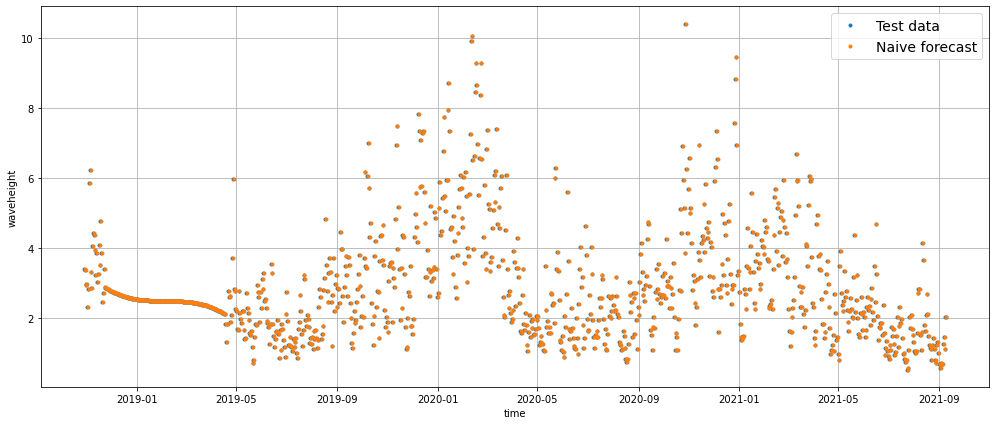

In [76]:
plt.figure(figsize=(17, 7))
offset = 0
nv_test = X_test
nv_val = y_test
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, label="Naive forecast",figname='naive_fore_cast')

In [77]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.64960307,
 'mape': 22.654089,
 'mase': 0.9990928,
 'mse': 0.95977396,
 'rmse': 0.97968054}

In [ ]:
# HORIZON = 1  # how far in the future 
# WINDOW_SIZE = 200 # how far in the past // lets do for 1 day at a time , there are methods to calculate confidence interval and stuff

In [78]:
def get_labelled_windows(x, horizon=1):
    #splitting data into two , past and future 
    return x[:, :-horizon], x[:, -horizon:]

In [79]:
def make_windows(x, window_size=7, horizon=1):
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [80]:
#test 
full_windows, full_labels = make_windows(waveperiod, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [0.943 1.025 1.508 4.283 3.875 3.354 2.462 3.262 2.321 2.408 1.904 1.467
 1.65  2.233 2.7   6.183 6.875 3.435 2.812 3.75  2.822 2.2   2.704 2.346
 1.933 1.942 1.529 1.408 1.954 1.646 2.375 1.971 2.196 1.948 1.962 1.354
 0.925 0.714 0.783 0.879 0.75  1.971 2.471 2.071 1.138 0.879 0.946 1.188
 1.762 1.567 1.308 1.462 1.988 3.229 2.125 2.208 2.533 2.138 1.912 2.75
 2.121 2.596 3.046 1.958 2.562 1.571 1.246 2.729 1.804 1.671 1.742 2.262
 1.704 1.225 1.425 1.783 1.729 1.467 1.1   0.925 0.779 1.279 1.411 2.729
 2.821 2.138 2.117 1.617 1.529 1.9  ] -> Label: [1.679]
Window: [1.025 1.508 4.283 3.875 3.354 2.462 3.262 2.321 2.408 1.904 1.467 1.65
 2.233 2.7   6.183 6.875 3.435 2.812 3.75  2.822 2.2   2.704 2.346 1.933
 1.942 1.529 1.408 1.954 1.646 2.375 1.971 2.196 1.948 1.962 1.354 0.925
 0.714 0.783 0.879 0.75  1.971 2.471 2.071 1.138 0.879 0.946 1.188 1.762
 1.567 1.308 1.462 1.988 3.229 2.125 2.208 2.533 2.138 1.912 2.75  2.121
 2.596 3.046 1.958 2.562 1.571 1.246 2.729 1.804 1.671

In [81]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split)) 
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [82]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)


np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

In [83]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                                verbose=0,
                                                save_best_only=True)

In [84]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                         
], name="model_1_dense") # model name 1 

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) 

# Fit model , some thing is wrong with this part overfitting
model_1.fit(x=train_windows, # train windows of 7 timesteps of waveperiod 1-7 days and then 7th day the target 
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day) a bit like naive 
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
33/33 [==============================] - 2s 31ms/step - loss: 0.7744 - mae: 0.7744 - val_loss: 0.9619 - val_mae: 0.9619
Epoch 2/100
33/33 [==============================] - 1s 21ms/step - loss: 0.5969 - mae: 0.5969 - val_loss: 0.8268 - val_mae: 0.8268
Epoch 3/100
33/33 [==============================] - 1s 22ms/step - loss: 0.5187 - mae: 0.5187 - val_loss: 0.7819 - val_mae: 0.7819
Epoch 4/100
33/33 [==============================] - 1s 23ms/step - loss: 0.5072 - mae: 0.5072 - val_loss: 0.7509 - val_mae: 0.7509
Epoch 5/100
33/33 [==============================] - 1s 22ms/step - loss: 0.5232 - mae: 0.5232 - val_loss: 0.7475 - val_mae: 0.7475
Epoch 6/100
33/33 [==============================] - 1s 21ms/step - loss: 0.5445 - mae: 0.5445 - val_loss: 0.7258 - val_mae: 0.7258
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4638 - mae: 0.4638 - val_loss: 0.7631 - val_mae: 0.7631
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.56

In [85]:
model_1.evaluate(test_windows, test_labels)
# print(test_windows,"======================",test_labels)

33/33 [==============================] - 0s 1ms/step - loss: 0.6887 - mae: 0.6887


[0.6887050867080688, 0.6887050867080688]

In [86]:
def make_preds(model, input_data):
    #print(input_data[0])
    forecast = model.predict(input_data)
    # print(forecast)
    return tf.squeeze(forecast)

In [87]:
model_1_preds = make_preds(model_1, test_windows)

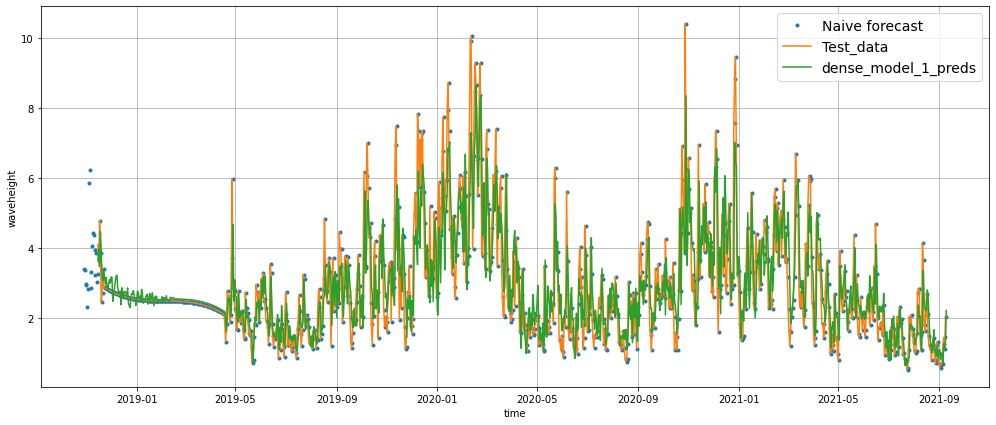

In [88]:
plt.figure(figsize=(17, 7))


# plot_time_series(timesteps=nv_test, values=nv_val, start=offset, label="Test data")
plot_time_series(timesteps=nv_test[1:], values=naive_forecast, start=offset, label="Naive forecast",figname='naive_fore_cast')

m1_test = X_test
m1_val = test_labels

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset,format="-", label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="dense_model_1_preds",figname=flnn + "_model1" )

In [89]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 0.68870515,
 'mape': 26.106197,
 'mase': 1.0634253,
 'mse': 0.95759535,
 'rmse': 0.978568}

In [90]:
# HORIZON = 1
# WINDOW_SIZE = 200

full_windows, full_labels = make_windows(waveperiod, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(4124, 1031, 4124, 1031)

In [91]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) 
# print(f"Original shape: {x.shape}") 
# print(f"Expanded shape: {expand_dims_layer(x).shape}") 
# print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

In [92]:
model_3 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_conv1D")

# Compile model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_3.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_conv1D/assets
INFO:tensorflow:Assets wr

In [93]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_conv1D")
model_3.evaluate(test_windows, test_labels)

33/33 [==============================] - 0s 2ms/step - loss: 0.6237


0.6236507296562195

In [94]:
model_3_preds = make_preds(model_3, test_windows)

In [95]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

model_3_results

{'mae': 0.6236507,
 'mape': 22.298346,
 'mase': 0.9629752,
 'mse': 0.8566248,
 'rmse': 0.92554027}

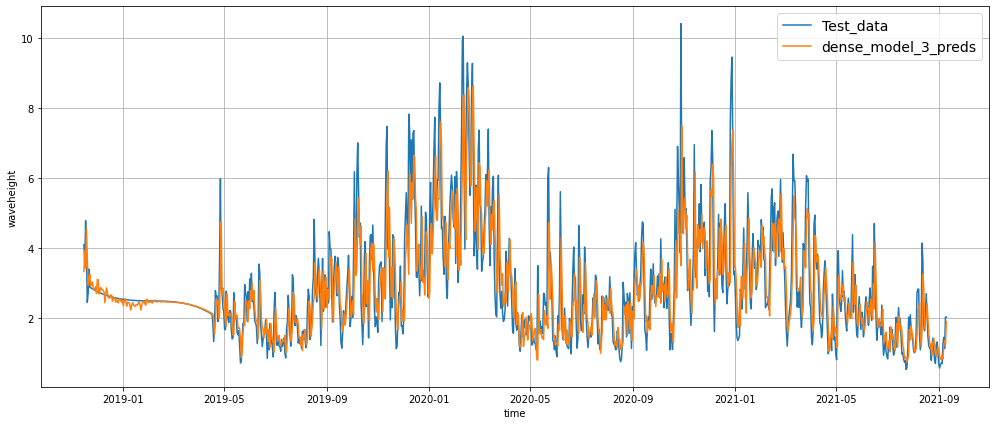

In [96]:
plt.figure(figsize=(17, 7))


# plot_time_series(timesteps=nv_test, values=nv_val, start=offset, label="Test data")
# plot_time_series(timesteps=nv_test[1:], values=naive_forecast, start=offset, label="Naive forecast",figname='naive_fore_cast')


plot_time_series(timesteps=m1_test[-len(test_windows):], values=m1_val[:, 0], start=offset,format="-", label="Test_data")
# plot_time_series(timesteps=m1_test[-len(test_windows):], values=model_1_preds, start=offset, format=".", label="dense_model_1_preds",figname='dense_model')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, format="-", label="dense_model_3_preds",figname=flnn + "conv_model")

In [97]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_4 = tf.keras.Model(inputs=inputs, outputs=output, name="model_4_lstm")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_lstm/assets


In [98]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_lstm/")


In [99]:
model_4_preds = make_preds(model_4, test_windows)


In [100]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)

model_4_results

{'mae': 0.6409196,
 'mape': 22.9951,
 'mase': 0.98964,
 'mse': 0.89902717,
 'rmse': 0.9481704}

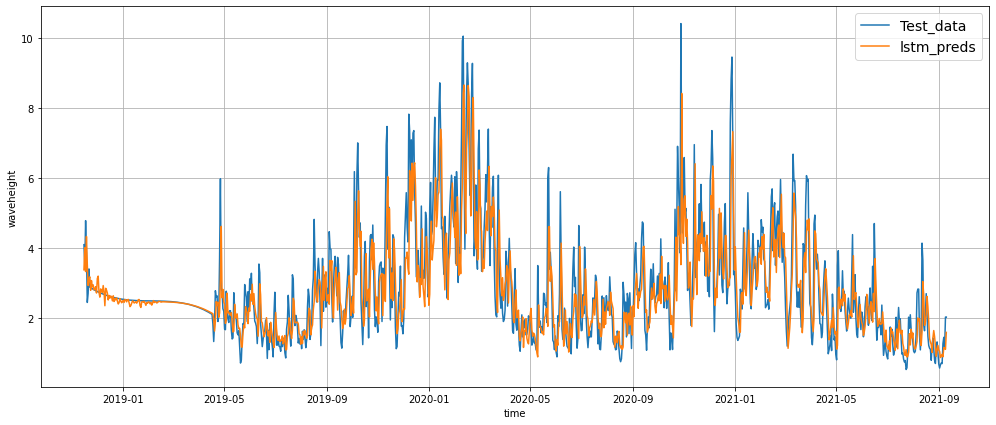

In [101]:
plt.figure(figsize=(17, 7))


# plot_time_series(timesteps=nv_test, values=nv_val, start=offset, label="Test data")
# plot_time_series(timesteps=nv_test[1:], values=naive_forecast, start=offset, label="Naive forecast",figname='naive_fore_cast')

m3_test = X_test
m4_test = X_test

plot_time_series(timesteps=m1_test[-len(test_windows):], values=m1_val[:, 0], start=offset,format="-", label="Test_data")
# plot_time_series(timesteps=m1_test[-len(test_windows):], values=model_1_preds, start=offset, format=".", label="dense_model_1_preds",figname='dense_model')
# plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, format=".", label="dense_model_3_preds",figname='dense_model')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_4_preds, start=offset, format="-", label="lstm_preds",figname=flnn + "_model_lstm")

In [102]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [103]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [104]:
waves_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  waves_nbeats[f"{for_col}+{i+1}"] = waves_nbeats[for_col].shift(periods=i+1)

waves_nbeats = waves_nbeats.filter(like=for_col)
# print(waves_nbeats.head(10))
waves_nbeats = waves_nbeats.dropna().head()
print(waves_nbeats.head())

            waveheight  waveheight+1  ...  waveheight+89  waveheight+90
date                                  ...                              
2007-08-01       1.679         1.900  ...          1.025          0.943
2007-08-02       1.904         1.679  ...          1.508          1.025
2007-08-03       2.671         1.904  ...          4.283          1.508
2007-08-04       5.867         2.671  ...          3.875          4.283
2007-08-05       3.442         5.867  ...          3.354          3.875

[5 rows x 91 columns]


In [105]:
waves_nbeats = df.copy()
print(len(waves_nbeats.index))
for i in range(WINDOW_SIZE):
  waves_nbeats[f"{for_col}+{i+1}"] = waves_nbeats[for_col].shift(periods=i+1)


# print(waves_nbeats)
print(len(waves_nbeats.index))
waves_nbeats = waves_nbeats.filter(like=for_col)
# print(waves_nbeats.head(10))
waves_nbeats = waves_nbeats.dropna()
#.head()
print(len(waves_nbeats.index))


X = waves_nbeats.dropna().drop(for_col, axis=1)
y = waves_nbeats.dropna()[for_col]

print(len(X))
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

5245
5245
5155
5155


(4124, 4124, 1031, 1031)

In [106]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

print(train_features_dataset,train_labels_dataset)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

print(train_features_dataset,train_labels_dataset)
# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))


# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

<TensorSliceDataset shapes: (90,), types: tf.float64> <TensorSliceDataset shapes: (), types: tf.float64>
<TensorSliceDataset shapes: (90,), types: tf.float64> <TensorSliceDataset shapes: (), types: tf.float64>


(<PrefetchDataset shapes: ((None, 90), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 90), (None,)), types: (tf.float64, tf.float64)>)

In [107]:
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(90, 91)

In [ ]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

print(backcast,forecast)

residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

KerasTensor(type_spec=TensorSpec(shape=(None, 90), dtype=tf.float32, name=None), name='InitialBlock/strided_slice:0', description="created by layer 'InitialBlock'") KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='InitialBlock/strided_slice_1:0', description="created by layer 'InitialBlock'")


In [ ]:
model_7.evaluate(test_dataset)
model_7_preds = make_preds(model_7, test_dataset)
print(model_7_preds[:10])

2/2 [==============================] - 1s 37ms/step - loss: 0.7135 - mae: 0.7135 - mse: 1.0916
tf.Tensor(
[3.5646107 3.5272014 3.200759  3.7511563 3.727884  3.4760654 3.3407276
 3.246294  3.1405942 3.2287128], shape=(10,), dtype=float32)


In [ ]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 0.71350294,
 'mape': 27.21084,
 'mase': 1.1017154,
 'mse': 1.0916054,
 'rmse': 1.0447992}

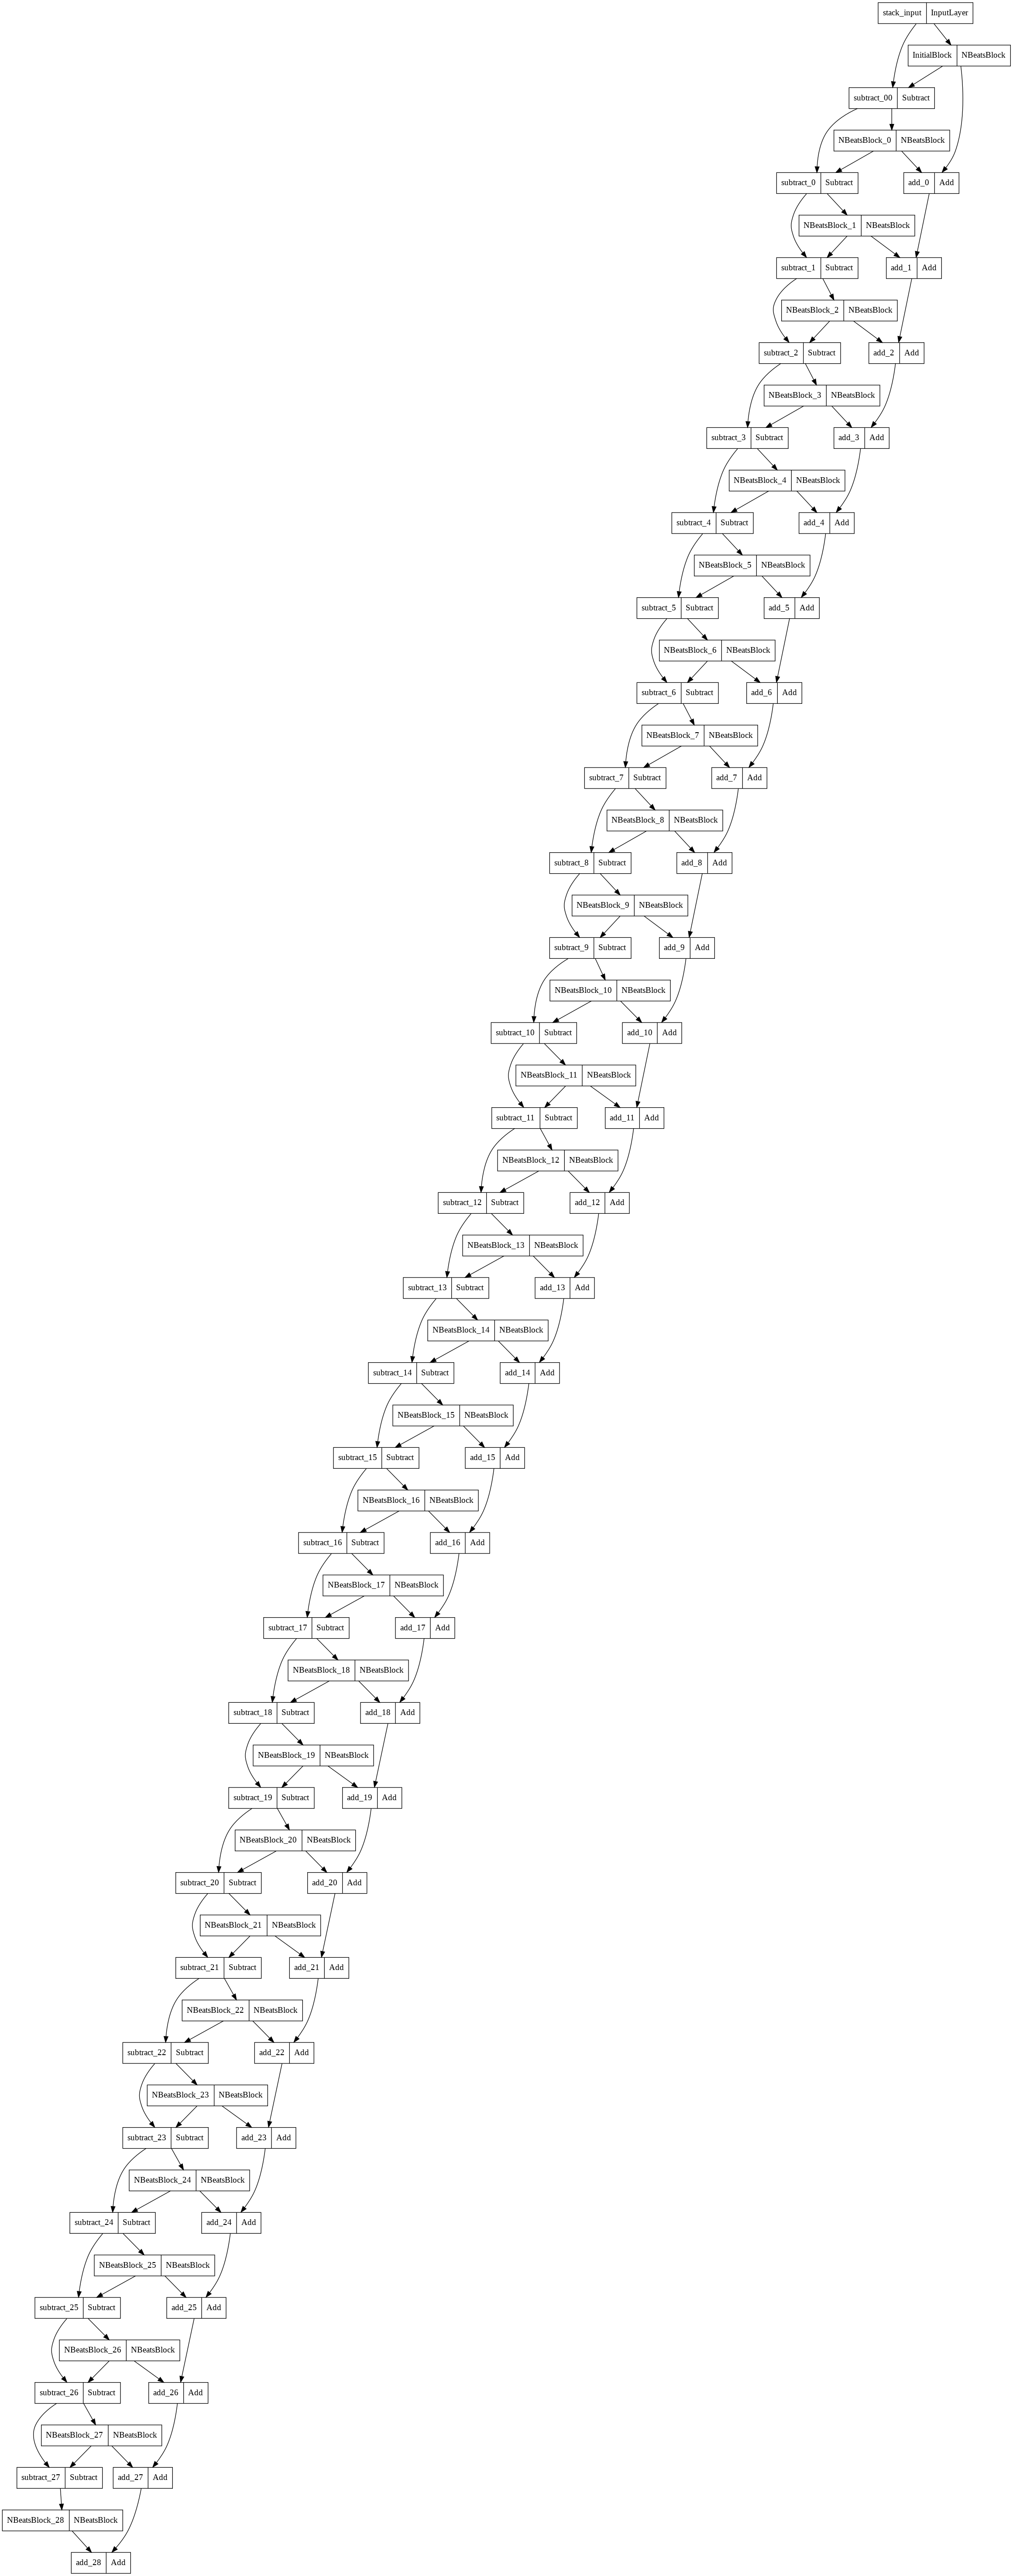

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

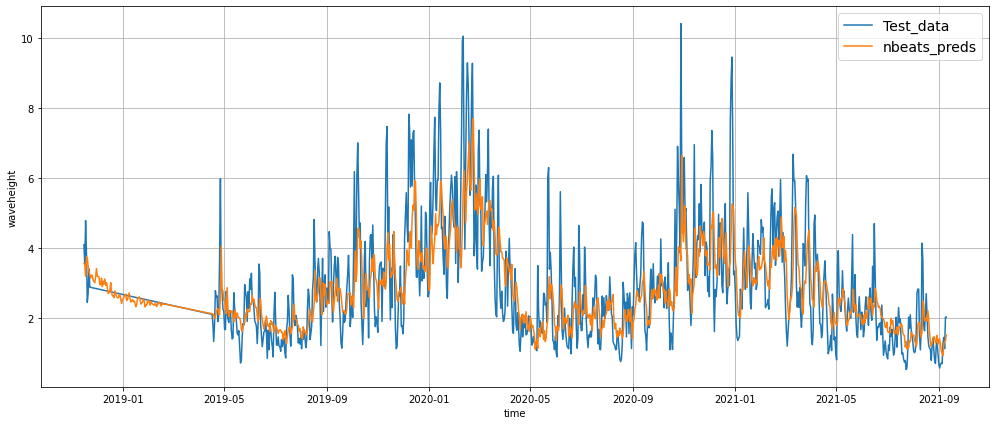

In [ ]:
plt.figure(figsize=(17, 7))

offset = 0
# plot_time_series(timesteps=nv_test, values=nv_val, start=offset, label="Test data")

plot_time_series(timesteps=m1_test[-len(test_windows):], values=m1_val[:, 0], start=offset,format="-", label="Test_data")
# plot_time_series(timesteps=nv_test[1:], values=naive_forecast, start=offset, label="Naive forecast",figname='naive_fore_cast')
# plot_time_series(timesteps=m1_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="dense_model_1_preds",figname='dense_model')
# plot_time_series(timesteps=m3_test[-len(test_windows):], values=model_3_preds, start=offset, format="-", label="conv1d_2_preds",figname='dense_model')
# plot_time_series(timesteps=m3_test[-len(test_windows):], values=model_4_preds, start=offset, format="-", label="lstm_preds",figname='dense_model')
plot_time_series(timesteps=m3_test[-len(test_windows):], values=model_7_preds, start=offset, format="-", label="nbeats_preds",figname=flnn + "_nbeats")